# Task 2: Ensembel Method

**Dataset Description**

This is a transnational dataset that contains all the transactions occurring between 2010 and 2011 for a UK-based online retail store.
Data dictionary
- InvoiceNo: Invoice number, a 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
- StockCode: Product (item) code, a 5-digit integral number uniquely assigned to each distinct product.
- Description: Product (item) name.
- Quantity: The quantities of each product (item) per transaction.
- InvoiceDate: Invoice Date and time. the day and time when each transaction was generated in d/m/yy h:m format
- UnitPrice: Unit price. Numeric, Product price per unit in sterling.
- CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
- Country: Country name. Nominal, the name of the country where each customer resides.

1. Remove rows with missing CustomerID. 

In [ ]:
#Import necessary libraries
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
from sklearn import tree, ensemble, model_selection, metrics, svm, linear_model, metrics
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint
from sklearn.inspection import permutation_importance
import shap
from matplotlib import pyplot as plt

In [ ]:
#Read file csv
data = pd.read_csv('transactions.csv')

In [ ]:
#Remove rows with missing CustomerID
data = data[data['Customer ID'].notnull()]

2. Remove cancelled transactions.

In [ ]:
#Remove cancelled transactions by removing invoices starting with 'C'
data = data[~data['Invoice'].str.startswith('C')]

3. Split the dataframe into two parts: 1) df_historical: transactions with invoiceDate earlier than 01 June 2011 and 2) df_future: transactions with invoiceDate on or later than 01 June 2011. 

In [ ]:
#Before spliting data, we remove duplicated rows
data = data.drop_duplicates()

In [ ]:
# Set the date 
date = dt.datetime(2011,6,1)
# Transaction before "date"
df_historical = data[data['InvoiceDate'].map(lambda x: datetime.strptime(x, '%d/%m/%y %H:%M'))<date]
# Transaction from "date"
df_future = data[data['InvoiceDate'].map(lambda x: datetime.strptime(x, '%d/%m/%y %H:%M'))>=date]

4. Create a new dataframe: df_train, which contains only one column: "Customer ID" from df_historical. Then create a new column "target" in df_train: target=1 if the customer had a purchase after or on 01 June 2011 and target=0 otherwise. 

In [ ]:
#Create df_train: select customer ID from df_historical and drop duplicated customer ID
df_train = df_historical[['Customer ID']].drop_duplicates(ignore_index = True)

#Create df_returned: select customer ID from df_future and drop duplicated customer ID
df_returned = df_future[['Customer ID']].drop_duplicates(ignore_index = True).rename({'Customer ID': 'Customer ID_r'}, axis = 1)

#Left join df_train and df_returned by customer id to see whether customers returned 
df_train = df_train.merge(df_returned, how = 'left', left_on = 'Customer ID', right_on = 'Customer ID_r')

#Create 'Target' column: who returned will be 1, otherwise 0
df_train = df_train.assign(Target= np.where(df_train['Customer ID_r'].isnull(), 0, 1))[['Customer ID','Target']]

5. Generate the following features

- Total amount of the historical transactions
- Total number of historical transactions (Note: One invoice may contain multiple items.) 
- Number of unique items from the historical transactions.

In [ ]:
# Total Amount of historical transactions
df_historical.loc[:,'Total amount'] = df_historical.loc[:,'Price']*df_historical.loc[:,'Quantity']
df_total_trans_amount = df_historical.groupby('Customer ID')['Total amount'].sum().reset_index()

# Number of historical transactions: 
df_num_trans = df_historical.groupby('Customer ID')['Invoice'].nunique().reset_index().rename({'Invoice':'Total trans'},axis = 1)

# Number of unique items: 
df_num_items = df_historical.groupby('Customer ID')['StockCode'].nunique().reset_index().rename({'StockCode':'Total items'},axis = 1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


- Create more features from the historical transactions. Make sure you don’t use future information. 

In [ ]:
###### Create 5 more attributes######

# 1. Average amount per trans
df_avg_trans_amount = df_historical.groupby(['Customer ID', 'Invoice'])['Total amount'].sum().reset_index()
df_avg_trans_amount =  df_avg_trans_amount.groupby(['Customer ID'])['Total amount'].mean().reset_index().rename({'Total amount':'Avg amount/trans'},axis = 1)

# 2. Maximum amount per trans
df_max_trans_amount = df_historical.groupby(['Customer ID', 'Invoice'])['Total amount'].sum().reset_index()
df_max_trans_amount =  df_max_trans_amount.groupby(['Customer ID'])['Total amount'].max().reset_index().rename({'Total amount':'Max amount/trans'},axis = 1)

# 3. Average number of unique items per trans
df_avg_uitems_per_trans = df_historical.groupby(['Customer ID', 'Invoice'])['StockCode'].nunique().reset_index()
df_avg_uitems_per_trans = df_avg_uitems_per_trans.groupby(['Customer ID'])['StockCode'].mean().reset_index().rename({'StockCode':'Avg_items/trans'},axis = 1)

# 4. The highest amount that customers pay for one item
df_max_trans_amount_per_item = df_historical.groupby(['Customer ID'])['Total amount'].max().reset_index().rename({'Total amount':'Max amount/item'},axis = 1)

# 5. Recency: number of days from the last purchase to the date of "2011-06-01"
df_historical.loc[:,'Recency'] = df_historical.loc[:,'InvoiceDate'].map(lambda x: datetime.strptime(x, '%d/%m/%y %H:%M')).dt.date 
df_historical.loc[:,'Recency'] = dt.datetime(2011,6,1) - pd.to_datetime(df_historical.loc[:,'Recency'])
df_recency = df_historical.groupby(['Customer ID'])['Recency'].min().reset_index()
df_recency.loc[:,'Recency'] = df_recency.loc[:,'Recency'].dt.days


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


After creating all attributes, we inner join all tables of attributes with df_train to create the final table.

In [ ]:
df_train = df_train.merge(df_total_trans_amount,on='Customer ID').merge(df_num_trans,on='Customer ID').merge(df_num_items,on='Customer ID').merge(df_avg_trans_amount,on='Customer ID').merge(df_max_trans_amount,on='Customer ID').merge(df_avg_uitems_per_trans,on='Customer ID').merge(df_max_trans_amount_per_item,on='Customer ID').merge(df_recency,on='Customer ID')

In [ ]:
# Overview of df_train
df_train.head(2)

,Customer ID,Target,Total amount,Total trans,Total items,Avg amount/trans,Max amount/trans,Avg_items/trans,Max amount/item,Recency
0,17850.0,0,5391.21,34,21,158.565000,532.01,8.735294,107.25,181
1,13047.0,1,1671.68,6,60,278.613333,458.90,13.666667,68.00,28


6. Split df_train into train and test and set test_size=0.2 and random_state=2022.

In [ ]:
x = df_train.iloc[:,2:] # Select attributes
y = df_train.iloc[:,1] #Select target

In [ ]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size = 0.2, random_state = 2022)

7. Train the following ensemble models based on the features you generated above. For each of the models, define your parameter search space and use either GridSearchCV or RandomizedSearchCV to find the best parameter combinations. 
- Decision Tree
- Random Forest
- Extra Tree
- Adaboost
- Gradient Boost
- SVM

In [ ]:
#First, we do feature scaling so that features have comparable ranges.
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

Now, we perform hyperparameters searching by using GridSearch or OptimizedSearch

Different models may require different hyperparameters. For common hyperparameters, I will keep them relatively the same accross models so that the results can be reasonably compared. The following are search space for common hyperparameters:
- 'criterion': ['gini', 'entropy'] 
- 'splitter': ['best', 'random']
- 'max_depth': from 2 to 9
- 'min_samples_split': from 3 to 20
- 'n_estimators': from 20 to 200
- 'n_estimators': from 1 to 5
- 'n_iter': 100

***Decision Tree***

In [ ]:
# Using Grid Search
# Search space
parameters = [
    {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9], 'min_samples_split': [5]},
    {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': [5], 'min_samples_split': [3, 5, 7, 9, 11, 13, 15, 17, 19]}
] 

# Start searching and fit model
dtree = model_selection.GridSearchCV(tree.DecisionTreeClassifier(random_state= 2022), parameters, cv=model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=2022))
dtree.fit(x_train, y_train)
print('best score:', dtree.best_score_)
print('best parameters: ', dtree.best_params_)

best score: 0.7060689975901577
best parameters:  {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 19, 'splitter': 'best'}


In [ ]:
# Using Randomized Search
parameters = [
    {'criterion': ['gini', 'entropy']
     , 'splitter': ['best', 'random']
     , 'max_depth': randint(2,20)
     , 'min_samples_split': randint(3,20)
     }
]

dtree = model_selection.RandomizedSearchCV(tree.DecisionTreeClassifier(random_state= 2022), parameters, n_iter=100, n_jobs=-1, cv=model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=2022))
dtree.fit(x_train, y_train)
print('best score:', dtree.best_score_)
print('best parameters: ', dtree.best_params_)

best score: 0.7060647697966431
best parameters:  {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 4, 'splitter': 'best'}


Amongst all experiments with different random_state, we noticed that the results of criterion: gini and splitter: best are consistently chosen to be the best parameters for decision tree model.

***Random Forest***

In [ ]:
# Using Grid Search
parameters = [
    {'criterion': ['gini', 'entropy'], 'n_estimators': [20], 'max_features':[1,2,3,4,5], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9], 'min_samples_split': [3]},
    {'criterion': ['gini', 'entropy'], 'n_estimators': [20,30,40,50,60,70,80,90,100,200], 'max_features':[1,2], 'max_depth': [2,3], 'min_samples_split': [3]}
]

rforest = model_selection.GridSearchCV(ensemble.RandomForestClassifier(random_state= 2022), parameters, cv=model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=2022))
rforest.fit(x_train, y_train)
print('best score:', rforest.best_score_)
print('best parameters: ', rforest.best_params_)

best score: 0.7102333742020039
best parameters:  {'criterion': 'entropy', 'max_depth': 5, 'max_features': 2, 'min_samples_split': 3, 'n_estimators': 20}


In [ ]:
# Using Randomized Search
parameters = [
    {'criterion': ['gini', 'entropy']
     , 'n_estimators': randint(20,200)
     , 'max_features':randint(1,8)
     , 'max_depth': randint(2,20)
     , 'min_samples_split':  randint(3,20)
     }
]

rforest = model_selection.RandomizedSearchCV(ensemble.RandomForestClassifier(random_state= 2022), parameters, n_iter=100, n_jobs=-1, cv=model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=2022))
rforest.fit(x_train, y_train)
print('best score:', rforest.best_score_)
print('best parameters: ', rforest.best_params_)

best score: 0.7083752589523528
best parameters:  {'criterion': 'gini', 'max_depth': 5, 'max_features': 1, 'min_samples_split': 7, 'n_estimators': 102}


As we can see from above results, Randomized Seach and Grid Search generates similar best scores. Thus, I will choose only one of them for the next models. I will utilize Randomized Search since by design, it will find the best parameter more efficiently than Grid Search.

***Extra Tree***

In [ ]:
# Using Randomized Search
parameters = [
    {'criterion': ['gini', 'entropy']
     , 'n_estimators': randint(20,200)
     , 'max_features':randint(1,8)
     , 'max_depth': randint(2,5)
     , 'min_samples_split': randint(2,8)
     }
]

extratree = model_selection.RandomizedSearchCV(ensemble.ExtraTreesClassifier(random_state= 2022)
            , parameters, n_iter=100, n_jobs=-1
            , cv=model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=2022))
extratree.fit(x_train, y_train)
print('best score:', extratree.best_score_)
print('best parameters: ', extratree.best_params_)

best score: 0.6991734663679026
best parameters:  {'criterion': 'gini', 'max_depth': 4, 'max_features': 2, 'min_samples_split': 6, 'n_estimators': 77}


***Adaboost***

In [ ]:
# Using Randomized Search
parameters = [
    { 'n_estimators': randint(20,200)
     , 'learning_rate': [0.1, 0.5, 1, 1.5, 2]
     ,  'algorithm' : ['SAMME','SAMME.R']
     }
]

adaboost = model_selection.RandomizedSearchCV(ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=2)
        ,random_state= 2022)
        , parameters, n_iter=100, n_jobs=-1, cv=model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=2022))
adaboost.fit(x_train, y_train)
print('best score:', adaboost.best_score_)
print('best parameters: ', adaboost.best_params_)

best score: 0.7115968376104511
best parameters:  {'algorithm': 'SAMME', 'learning_rate': 1, 'n_estimators': 32}


***Gradient Boost***

In [ ]:
# Using Randomized Search
parameters = [
    {'loss': ['deviance']
     , 'n_estimators': randint(20,200)
     , 'learning_rate': [0.1]
     , 'min_samples_split': [3]
     , 'max_depth': randint(2,5)
     , 'max_features': [1,3,5,7]
     }
]

graboost = model_selection.RandomizedSearchCV(ensemble.GradientBoostingClassifier(random_state= 2022), parameters, n_iter=100, n_jobs=-1, cv=model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=2022))
graboost.fit(x_train, y_train)
print('best score:', graboost.best_score_)
print('best parameters: ', graboost.best_params_)

best score: 0.7070054538536338
best parameters:  {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 2, 'max_features': 3, 'min_samples_split': 3, 'n_estimators': 41}


***SVM***

In [ ]:
# Using Randomized Search
parameters = [
    {'C':[0.1,1,2]
     , 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
     , 'gamma' : ['scale', 'auto']
     , 'degree': randint(2,4)
     }
]

svmm = model_selection.RandomizedSearchCV(svm.SVC(probability=True,random_state= 2022), parameters, n_iter=100, n_jobs=-1, cv=model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=2022))
svmm.fit(x_train, y_train)
print('best score:', svmm.best_score_)
print('best parameters: ', svmm.best_params_)

best score: 0.6991734663679026
best parameters:  {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}


**Results:**
- We can see that the difference in best scores accross models is not significant. This shows that ensemble method does not necessarily gives us a considerable improvement compared to decision tree.

8. List the 5 most important features for Random Forest classifier.

Text(0.5, 0, 'Random Forest Feature Importance')

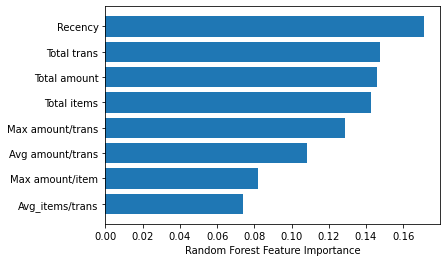

In [ ]:
#Random Forest Built-in Feature Importance
#Note: This method tends to favor the attributes with high cardinality.
sorted_idx = rforest.best_estimator_.feature_importances_.argsort()
plt.barh(x.columns[sorted_idx], rforest.best_estimator_.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

Text(0.5, 0, 'Random Forest Feature Importance')

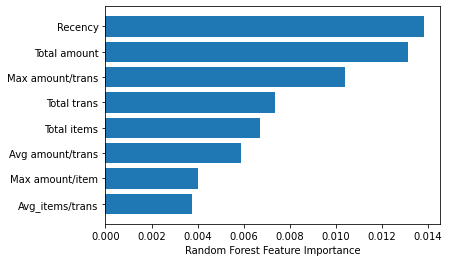

In [ ]:
#Permutation Based Feature Importance
#This method is better than the built in feature performance in the sense that it is less biased toward features with high cardinality
result = permutation_importance(rforest.best_estimator_, x_train, y_train, n_repeats=10, random_state=2022)
sorted_idx = result.importances_mean.argsort()
plt.barh(x.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

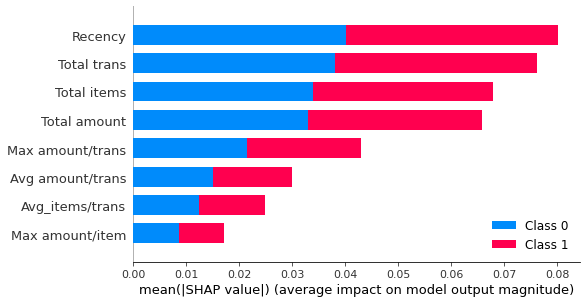

In [ ]:
#Feature Importance Computed with SHAP Values
#SHAP values are provided based on game theory
explainer = shap.TreeExplainer(rforest.best_estimator_)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values, x_train, plot_type="bar", feature_names = x.columns)

**Results:**
- For the top 4 most important features, the three methods provide the same results. They are total trans, total amount, recency and total items, although their specific rankings are different.
- For the 5th position, the result is not consistent. As Shap values is the least biased method, I choose the result provided by SHAP: avg amount/trans.

9. Build a stacking model based on the above classifiers. 

In [ ]:
# Estimator list
est_list = [('Decision Tree', dtree.best_estimator_),
                    ('Random Forest', rforest.best_estimator_),
                    ('Extra Tree', extratree.best_estimator_),
                    ('AdaBoost', adaboost.best_estimator_),
                    ('GradientBoost', graboost.best_estimator_),
                    ('SVM', svmm.best_estimator_)
                ]
# We choose logistic regression as our meta classifier
final_learner = linear_model.LogisticRegression()

# Fitting the model
stack_model = ensemble.StackingClassifier(estimators=est_list, final_estimator=final_learner)
stack_model.fit(x_train,y_train)

StackingClassifier(estimators=[('Decision Tree',
                                DecisionTreeClassifier(max_depth=5,
                                                       min_samples_split=4,
                                                       random_state=2022)),
                               ('Random Forest',
                                RandomForestClassifier(max_depth=5,
                                                       max_features=1,
                                                       min_samples_split=7,
                                                       n_estimators=102,
                                                       random_state=2022)),
                               ('Extra Tree',
                                ExtraTreesClassifier(max_depth=4,
                                                     max_features=2,
                                                     min_samples_split=6,
                                                     n_estimato

10. Report the model performance in terms of precision, recall, F1, and ROC_AUC on the train and test sets for the individual classifiers and the meta classifier.

In [ ]:
# Score results for Training Data
print("Precision Score:")
print("   Decision Tree :" ,round(metrics.precision_score(y_train, dtree.best_estimator_.predict(x_train)),3))
print("   Random Forest :" ,round(metrics.precision_score(y_train, rforest.best_estimator_.predict(x_train)),3))
print("   Extra Tree    :" ,round(metrics.precision_score(y_train, extratree.best_estimator_.predict(x_train)),3))
print("   Gradient Boost:" ,round(metrics.precision_score(y_train, graboost.best_estimator_.predict(x_train)),3))
print("   Ada Boost     :" ,round(metrics.precision_score(y_train, adaboost.best_estimator_.predict(x_train)),3))
print("   SVM           :" ,round(metrics.precision_score(y_train, svmm.best_estimator_.predict(x_train)),3))
print("   Stack model   :" ,round(metrics.precision_score(y_train, stack_model.predict(x_train)),3))

print("\nRecall Score:")
print("   Decision Tree :" ,round(metrics.recall_score(y_train, dtree.best_estimator_.predict(x_train)),3))
print("   Random Forest :" ,round(metrics.recall_score(y_train, rforest.best_estimator_.predict(x_train)),3))
print("   Extra Tree    :" ,round(metrics.recall_score(y_train, extratree.best_estimator_.predict(x_train)),3))
print("   Gradient Boost:" ,round(metrics.recall_score(y_train, graboost.best_estimator_.predict(x_train)),3))
print("   Ada Boost     :" ,round(metrics.recall_score(y_train, adaboost.best_estimator_.predict(x_train)),3))
print("   SVM           :" ,round(metrics.recall_score(y_train, svmm.best_estimator_.predict(x_train)),3))
print("   Stack model   :" ,round(metrics.recall_score(y_train, stack_model.predict(x_train)),3))

print("\nF1 Score:")
print("   Decision Tree :" ,round(metrics.f1_score(y_train, dtree.best_estimator_.predict(x_train)),3))
print("   Random Forest :" ,round(metrics.f1_score(y_train, rforest.best_estimator_.predict(x_train)),3))
print("   Extra Tree    :" ,round(metrics.f1_score(y_train, extratree.best_estimator_.predict(x_train)),3))
print("   Gradient Boost:" ,round(metrics.f1_score(y_train, graboost.best_estimator_.predict(x_train)),3))
print("   Ada Boost     :" ,round(metrics.f1_score(y_train, adaboost.best_estimator_.predict(x_train)),3))
print("   SVM           :" ,round(metrics.f1_score(y_train, svmm.best_estimator_.predict(x_train)),3))
print("   Stack model   :" ,round(metrics.f1_score(y_train, stack_model.predict(x_train)),3))

print("\nROC AUC Score:")
print("   Decision Tree :" ,round(metrics.roc_auc_score(y_train, dtree.best_estimator_.predict_proba(x_train)[:,1]),3))
print("   Random Forest :" ,round(metrics.roc_auc_score(y_train, rforest.best_estimator_.predict_proba(x_train)[:,1]),3))
print("   Extra Tree    :" ,round(metrics.roc_auc_score(y_train, extratree.best_estimator_.predict_proba(x_train)[:,1]),3))
print("   Gradient Boost:" ,round(metrics.roc_auc_score(y_train, graboost.best_estimator_.predict_proba(x_train)[:,1]),3))
print("   Ada Boost     :" ,round(metrics.roc_auc_score(y_train, adaboost.best_estimator_.predict_proba(x_train)[:,1]),3))
print("   SVM           :" ,round(metrics.roc_auc_score(y_train, svmm.best_estimator_.predict_proba(x_train)[:,1]),3))
print("   Stack model   :" ,round(metrics.roc_auc_score(y_train, stack_model.predict_proba(x_train)[:,1]),3))

Precision Score:
   Decision Tree : 0.791
   Random Forest : 0.744
   Extra Tree    : 0.699
   Gradient Boost: 0.743
   Ada Boost     : 0.774
   SVM           : 0.699
   Stack model   : 0.761

Recall Score:
   Decision Tree : 0.872
   Random Forest : 0.943
   Extra Tree    : 1.0
   Gradient Boost: 0.939
   Ada Boost     : 0.841
   SVM           : 1.0
   Stack model   : 0.915

F1 Score:
   Decision Tree : 0.83
   Random Forest : 0.832
   Extra Tree    : 0.823
   Gradient Boost: 0.83
   Ada Boost     : 0.806
   SVM           : 0.823
   Stack model   : 0.831

ROC AUC Score:
   Decision Tree : 0.79
   Random Forest : 0.805
   Extra Tree    : 0.734
   Gradient Boost: 0.773
   Ada Boost     : 0.758
   SVM           : 0.644
   Stack model   : 0.792


In [ ]:
# Score results for Test Data
print("Precision Score:")
print("   Decision Tree :" ,round(metrics.precision_score(y_test, dtree.best_estimator_.predict(x_test)),3))
print("   Random Forest :" ,round(metrics.precision_score(y_test, rforest.best_estimator_.predict(x_test)),3))
print("   Extra Tree    :" ,round(metrics.precision_score(y_test, extratree.best_estimator_.predict(x_test)),3))
print("   Gradient Boost:" ,round(metrics.precision_score(y_test, graboost.best_estimator_.predict(x_test)),3))
print("   Ada Boost     :" ,round(metrics.precision_score(y_test, adaboost.best_estimator_.predict(x_test)),3))
print("   SVM           :" ,round(metrics.precision_score(y_test, svmm.best_estimator_.predict(x_test)),3))
print("   Stack model   :" ,round(metrics.precision_score(y_test, stack_model.predict(x_test)),3))

print("\nRecall Score:")
print("   Decision Tree :" ,round(metrics.recall_score(y_test, dtree.best_estimator_.predict(x_test)),3))
print("   Random Forest :" ,round(metrics.recall_score(y_test, rforest.best_estimator_.predict(x_test)),3))
print("   Extra Tree    :" ,round(metrics.recall_score(y_test, extratree.best_estimator_.predict(x_test)),3))
print("   Gradient Boost:" ,round(metrics.recall_score(y_test, graboost.best_estimator_.predict(x_test)),3))
print("   Ada Boost     :" ,round(metrics.recall_score(y_test, adaboost.best_estimator_.predict(x_test)),3))
print("   SVM           :" ,round(metrics.recall_score(y_test, svmm.best_estimator_.predict(x_test)),3))
print("   Stack model   :" ,round(metrics.recall_score(y_test, stack_model.predict(x_test)),3))

print("\nF1 Score:")
print("   Decision Tree :" ,round(metrics.f1_score(y_test, dtree.best_estimator_.predict(x_test)),3))
print("   Random Forest :" ,round(metrics.f1_score(y_test, rforest.best_estimator_.predict(x_test)),3))
print("   Extra Tree    :" ,round(metrics.f1_score(y_test, extratree.best_estimator_.predict(x_test)),3))
print("   Gradient Boost:" ,round(metrics.f1_score(y_test, graboost.best_estimator_.predict(x_test)),3))
print("   Ada Boost     :" ,round(metrics.f1_score(y_test, adaboost.best_estimator_.predict(x_test)),3))
print("   SVM           :" ,round(metrics.f1_score(y_test, svmm.best_estimator_.predict(x_test)),3))
print("   Stack model   :" ,round(metrics.f1_score(y_test, stack_model.predict(x_test)),3))

print("\nROC AUC Score:")
print("   Decision Tree :" ,round(metrics.roc_auc_score(y_test, dtree.best_estimator_.predict_proba(x_test)[:,1]),3))
print("   Random Forest :" ,round(metrics.roc_auc_score(y_test, rforest.best_estimator_.predict_proba(x_test)[:,1]),3))
print("   Extra Tree    :" ,round(metrics.roc_auc_score(y_test, extratree.best_estimator_.predict_proba(x_test)[:,1]),3))
print("   Gradient Boost:" ,round(metrics.roc_auc_score(y_test, graboost.best_estimator_.predict_proba(x_test)[:,1]),3))
print("   Ada Boost     :" ,round(metrics.roc_auc_score(y_test, adaboost.best_estimator_.predict_proba(x_test)[:,1]),3))
print("   SVM           :" ,round(metrics.roc_auc_score(y_test, svmm.best_estimator_.predict_proba(x_test)[:,1]),3))
print("   Stack model   :" ,round(metrics.roc_auc_score(y_test, stack_model.predict_proba(x_test)[:,1]),3))

Precision Score:
   Decision Tree : 0.788
   Random Forest : 0.774
   Extra Tree    : 0.75
   Gradient Boost: 0.773
   Ada Boost     : 0.808
   SVM           : 0.75
   Stack model   : 0.78

Recall Score:
   Decision Tree : 0.838
   Random Forest : 0.941
   Extra Tree    : 1.0
   Gradient Boost: 0.926
   Ada Boost     : 0.836
   SVM           : 1.0
   Stack model   : 0.904

F1 Score:
   Decision Tree : 0.812
   Random Forest : 0.85
   Extra Tree    : 0.857
   Gradient Boost: 0.843
   Ada Boost     : 0.822
   SVM           : 0.857
   Stack model   : 0.838

ROC AUC Score:
   Decision Tree : 0.744
   Random Forest : 0.77
   Extra Tree    : 0.737
   Gradient Boost: 0.759
   Ada Boost     : 0.738
   SVM           : 0.645
   Stack model   : 0.761


Below is the summary table of all scores. The exact numbers may change slightly after each time we rerun the codes.


| Model  | Train_Precision | Train_Recall | Train_F1   | Train_AUC |-- |Test_Precision | Test_Recall | Test_F1   | Test_AUC |
|--------|---------------|------------------|-----------|-----------|----|---------------|------------------|-----------|-----------|
| Decision Tree | 0.791   |0.872  |0.83  | 0.79   ||0.788 |0.838  |0.812 |0.744|
| Random Forest |  0.744  | 0.943 |0.832   |0.805 ||0.774 |0.941  |0.85  |0.77|
| Extra Tree    | 0.699   | 1.0   | 0.823   |0.734||0.75  |1.0    |0.857 |0.737|
| Gradient boost | 0.743  |  0.939  |0.83  |0.773 ||0.773 |0.926  |0.843  |0.759|
| Adaboost     |  0.774   |  0.841  |0.806 |0.758 ||0.808 |0.836  |0.822 |0.738|
| SVM        | 0.699      |1.0    |0.823   |0.644 ||0.75  |1.0    |0.857 |0.645|
| Stacking model | 0.761  |0.915   | 0.831  |0.792||0.778 |0.904  |0.838 |0.761|

**Results:**
- In predicting retention rate, we prefer precision (to reduce false positive) when we want to maximize retetion rate and prefer recall (to reduce false negative) when we want to reduce the retention costs. Based on the table summary, Adaboost is the best model in terms of precision. Extra Tree and SVM, while do not perform well in terms of Precision compared to others, are able to achieve perfect Recall and thus gain the highest scores in F1 score. 
- All models achives a higher score on Recall than Precision.
- Stacking model does not clearly outperform others with respect to any metrics. This indicates that a more complex model is not necessarily better. 
- Decision Tree shows a sign of overfitting as its scores on Test dataset are lower than those for train dataset. 

11. Plot the ROC curve of all the above models based on the evaluation of the test set.

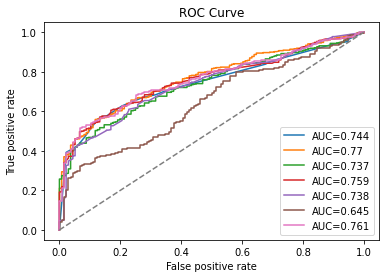

In [ ]:
# list of models
models = [dtree, rforest, extratree, graboost, adaboost, svmm, stack_model]

# Create list of AUC score
Test_AUC = []
for m in models:
    if m != stack_model:
        Test_AUC.append(round(metrics.roc_auc_score(y_test, m.best_estimator_.predict_proba(x_test)[:,1]),3))
    else:
        Test_AUC.append(round(metrics.roc_auc_score(y_test, m.predict_proba(x_test)[:,1]),3))

# Plot ROC curves
for m in models:
    fpr, tpr, thresholds = metrics.roc_curve(y_test, m.predict_proba(x_test)[:,1], pos_label = 1)
    plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], ls = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend( ['AUC='+str(i) for i in Test_AUC],loc="lower right")
plt.show()

It can be seen that Random Forest is the best model in terms of ROC curve